In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# List of Dow Jones 30 stocks
tickers = [
    "AAPL", "MSFT", "NVDA", "GOOG", "AMZN", "META",
    "BRK-B", "LLY", "AVGO", "TSLA", "WMT", "JPM", 
    "V", "UNH", "XOM", "ORCL", "MA", "HD", "PG", 
    "COST", "^SPX"
]
# Ticker for the benchmark
benchmark = '^SPX'

# Load the data from CSV files
stock_data = {}
for ticker in tickers:
    df = pd.read_csv(f'./data/us_stock/all_{ticker}.csv', index_col='Date', parse_dates=True)
    stock_data[ticker] = df

# Define the time ranges for training, validation, and test datasets
training_data_time_range = ('2014-01-01', '2020-12-31')
validation_data_time_range = ('2021-01-01', '2022-12-31')
test_data_time_range = ('2023-01-01', '2024-10-31')

# Split the data into training, validation, and test datasets
training_data = {}
validation_data = {}
test_data = {}

for ticker, df in stock_data.items():
    training_data[ticker] = df.loc[training_data_time_range[0]:training_data_time_range[1]]
    validation_data[ticker] = df.loc[validation_data_time_range[0]:validation_data_time_range[1]]
    test_data[ticker] = df.loc[test_data_time_range[0]:test_data_time_range[1]]

# Print the shape of training, validation, and test data
ticker = 'AAPL'
print(f'Training data shape for {ticker}: {training_data[ticker].shape}')
print(f'Validation data shape for {ticker}: {validation_data[ticker].shape}')
print(f'Test data shape for {ticker}: {test_data[ticker].shape}')

# Display the first 5 rows of the data for AAPL
stock_data['AAPL'].head()


Training data shape for AAPL: (1763, 9)
Validation data shape for AAPL: (503, 9)
Test data shape for AAPL: (461, 9)


,Open,High,Low,Close,Adj Close,Volume,Fear Greed,Put Call,VIX
Date,,,,,,,,,
2014-01-02,19.845715,19.893929,19.715000,19.754642,17.234297,234684800,71.0,0.56,14.23
2014-01-03,19.745001,19.775000,19.301071,19.320715,16.855734,392467600,66.0,0.54,13.76
2014-01-06,19.194643,19.528570,19.057142,19.426071,16.947647,412610800,64.0,0.52,13.55
2014-01-07,19.440001,19.498571,19.211430,19.287144,16.826441,317209200,67.0,0.47,12.92
2014-01-08,19.243214,19.484285,19.238930,19.409286,16.933006,258529600,64.0,0.50,12.87


In [4]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

class StockTradingEnv(gym.Env):
    metadata = {'render_modes': ['human']}
    
    def __init__(self, stock_data):
        super(StockTradingEnv, self).__init__()
        
        # Remove any empty DataFrames
        self.stock_data = {ticker: df for ticker, df in stock_data.items() if not df.empty}
        self.tickers = list(self.stock_data.keys())
        
        if not self.tickers:
            raise ValueError("All provided stock data is empty")
        
        # Calculate the size of one stock's data
        sample_df = next(iter(self.stock_data.values()))
        self.n_features = len(sample_df.columns)
        
        # Define action and observation space
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers),), dtype=np.float32)
        
        # Observation space: price data for each stock + balance + shares held + net worth + max net worth
        self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)
        
        # Initialize account balance
        self.initial_balance = 1000
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}
        
        # Set the current step
        self.current_step = 0
        
        # Calculate the minimum length of data across all stocks
        self.max_steps = max(0, min(len(df) for df in self.stock_data.values()) - 1)
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}
        self.current_step = 0
        return self._next_observation(), {}
    
    def _next_observation(self):
        frame = np.zeros(self.obs_shape)
        
        idx = 0
        for ticker in self.tickers:
            df = self.stock_data[ticker]
            if self.current_step < len(df):
                frame[idx:idx+self.n_features] = df.iloc[self.current_step].values
            elif len(df) > 0:
                frame[idx:idx+self.n_features] = df.iloc[-1].values
            idx += self.n_features
        
        frame[-4-len(self.tickers)] = self.balance
        frame[-3-len(self.tickers):-3] = [self.shares_held[ticker] for ticker in self.tickers]
        frame[-3] = self.net_worth
        frame[-2] = self.max_net_worth
        frame[-1] = self.current_step
        
        return frame
    
    def step(self, actions):
        self.current_step += 1
        
        if self.current_step > self.max_steps:
            return self._next_observation(), 0, True, False, {}
        
        current_prices = {}
        for i, ticker in enumerate(self.tickers):
            current_prices[ticker] = self.stock_data[ticker].iloc[self.current_step]['Close']
            action = actions[i]
            
            if action > 0:  # Buy
                shares_to_buy = int(self.balance * action / current_prices[ticker])
                cost = shares_to_buy * current_prices[ticker]
                self.balance -= cost
                self.shares_held[ticker] += shares_to_buy
            elif action < 0:  # Sell
                shares_to_sell = int(self.shares_held[ticker] * abs(action))
                sale = shares_to_sell * current_prices[ticker]
                self.balance += sale
                self.shares_held[ticker] -= shares_to_sell
                self.total_shares_sold[ticker] += shares_to_sell
                self.total_sales_value[ticker] += sale
        
        self.net_worth = self.balance + sum(self.shares_held[ticker] * current_prices[ticker] for ticker in self.tickers)
        self.max_net_worth = max(self.net_worth, self.max_net_worth)
        
        reward = self.net_worth - self.initial_balance
        done = self.net_worth <= 0 or self.current_step >= self.max_steps
        
        obs = self._next_observation()
        return obs, reward, done, False, {}
    
    def render(self, mode='human'):
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance:.2f}')
        for ticker in self.tickers:
            print(f'{ticker} Shares held: {self.shares_held[ticker]}')
        print(f'Net worth: {self.net_worth:.2f}')
        print(f'Profit: {profit:.2f}')

    def close(self):
        pass

    def update_stock_data(self, new_stock_data):
        """
        Update the environment with new stock data.

        Parameters:
        new_stock_data (dict): Dictionary containing new stock data,
                                where keys are stock tickers and values are DataFrames.
        """
        # Remove any empty DataFrames
        self.stock_data = {ticker: df for ticker, df in new_stock_data.items() if not df.empty}
        self.tickers = list(self.stock_data.keys())

        if not self.tickers:
            raise ValueError("All new stock data is empty")

        # Update the number of features if needed
        sample_df = next(iter(self.stock_data.values()))
        self.n_features = len(sample_df.columns)

        # Update the observation space
        self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)

        # Update the maximum number of steps
        self.max_steps = max(0, min(len(df) for df in self.stock_data.values()) - 1)

        # Reset the environment
        self.reset()

        print(f"The environment has been updated with {len(self.tickers)} new stocks.")


In [5]:
from stable_baselines3 import PPO, A2C, DDPG
from stable_baselines3.common.vec_env import DummyVecEnv

# Define Ensemble Agent
class EnsembleAgent:
    def __init__(self, ppo_model, a2c_model, ddpg_model):
        self.ppo_model = ppo_model
        self.a2c_model = a2c_model
        self.ddpg_model = ddpg_model
    
    def predict(self, obs):
        ppo_action, _ = self.ppo_model.predict(obs)
        a2c_action, _ = self.a2c_model.predict(obs)
        ddpg_action, _ = self.ddpg_model.predict(obs)
        
        # Average the actions
        ensemble_action = np.mean([ppo_action, a2c_action, ddpg_action], axis=0)
        return ensemble_action
    
# Define PPO Agent
class PPOAgent:
    def __init__(self, env, total_timesteps):
        self.model = PPO("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action
    
# Define A2C Agent
class A2CAgent:
    def __init__(self, env, total_timesteps):
        self.model = A2C("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action
    
# Define DDPG Agent
class DDPGAgent:
    def __init__(self, env, total_timesteps):
        self.model = DDPG("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action


In [6]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to create the environment and train the agents
def create_env_and_train_agents(data, total_timesteps):
    # Create the environment using DummyVecEnv with training data
    env = DummyVecEnv([lambda: StockTradingEnv(data)])

    # Train PPO Agent
    ppo_agent = PPOAgent(env, total_timesteps)

    # Train A2C Agent
    a2c_agent = A2CAgent(env, total_timesteps)

    # Train DDPG Agent
    ddpg_agent = DDPGAgent(env, total_timesteps)

    # Train the ensemble agent
    ensemble_agent = EnsembleAgent(ppo_agent.model, a2c_agent.model, ddpg_agent.model)
    
    return env, ppo_agent, a2c_agent, ddpg_agent, ensemble_agent



In [7]:
import matplotlib.pyplot as plt

# Function to visualize portfolio changes
def visualize_portfolio(steps, balances, net_worths, shares_held, tickers, show_balance=True, show_net_worth=True, show_shares_held=True):
    fig, axs = plt.subplots(3, figsize=(12, 18))

    # Plot the balance
    if show_balance:
        axs[0].plot(steps, balances, label='Balance')
        axs[0].set_title('Balance Over Time')
        axs[0].set_xlabel('Steps')
        axs[0].set_ylabel('Balance')
        axs[0].legend()

    # Plot the net worth
    if show_net_worth:
        axs[1].plot(steps, net_worths, label='Net Worth', color='orange')
        axs[1].set_title('Net Worth Over Time')
        axs[1].set_xlabel('Steps')
        axs[1].set_ylabel('Net Worth')
        axs[1].legend()

    # Plot the shares held
    if show_shares_held:
        for ticker in tickers:
            axs[2].plot(steps, shares_held[ticker], label=f'Shares Held: {ticker}')
        axs[2].set_title('Shares Held Over Time')
        axs[2].set_xlabel('Steps')
        axs[2].set_ylabel('Shares Held')
        axs[2].legend()

    plt.tight_layout()
    plt.show()

# function to visualize the portfolio net worth
def visualize_portfolio_net_worth(steps, net_worths):
    plt.figure(figsize=(12, 6))
    plt.plot(steps, net_worths, label='Net Worth', color='orange')
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()

# function to visualize the multiple portfolio net worths ( same chart )
def visualize_multiple_portfolio_net_worth(steps, net_worths_list, labels):
    plt.figure(figsize=(12, 6))
    for i, net_worths in enumerate(net_worths_list):
        plt.plot(steps, net_worths, label=labels[i])
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()

In [8]:


def test_agent(env, agent, stock_data, n_tests=1000, visualize=False):
    """
    Test a single agent and track performance metrics, with an option to visualize the results.

    Parameters:
    - env: The trading environment.
    - agent: The agent to be tested.
    - stock_data: Data for the stocks in the environment.
    - n_tests: Number of tests to run (default: 1000).
    - visualize: Boolean flag to enable or disable visualization (default: False).

    Returns:
    - A dictionary containing steps, balances, net worths, and shares held.
    """
    # Initialize metrics tracking
    metrics = {
        'steps': [],
        'balances': [],
        'net_worths': [],
        'shares_held': {ticker: [] for ticker in stock_data.keys()}
    }

    # Reset the environment before starting the tests
    obs = env.reset()

    for i in range(n_tests):
        metrics['steps'].append(i)
        action = agent.predict(obs)
        obs, rewards, dones, infos = env.step(action)
        if visualize:
            env.render()

        # Track metrics
        metrics['balances'].append(env.get_attr('balance')[0])
        metrics['net_worths'].append(env.get_attr('net_worth')[0])
        env_shares_held = env.get_attr('shares_held')[0]

        # Update shares held for each ticker
        for ticker in stock_data.keys():
            if ticker in env_shares_held:
                metrics['shares_held'][ticker].append(env_shares_held[ticker])
            else:
                metrics['shares_held'][ticker].append(0)  # Append 0 if ticker is not found

        if dones:
            obs = env.reset()
            
    return metrics



In [9]:
def test_and_visualize_agents(env, agents, training_data, n_tests=1000):
    metrics = {}
    for agent_name, agent in agents.items():
        print(f"Testing {agent_name}...")
        metrics[agent_name] = test_agent(env, agent, training_data, n_tests=n_tests, visualize=True)
        print(f"Done testing {agent_name}!")
    
    print('-'*50)
    print('All agents tested!')
    print('-'*50)

    # Extract net worths for visualization
    net_worths = [metrics[agent_name]['net_worths'] for agent_name in agents.keys()]
    steps = next(iter(metrics.values()))['steps']  # Assuming all agents have the same step count for simplicity

    # Visualize the performance metrics of multiple agents
    visualize_multiple_portfolio_net_worth(steps, net_worths, list(agents.keys()))

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compare_and_plot_agents(agents_metrics, labels):
    # Function to compare returns, standard deviation, and sharpe ratio of agents
    def compare_agents(agents_metrics, labels):
        returns = []
        stds = []
        sharpe_ratios = []

        for metrics in agents_metrics:
            returns.append(np.mean(metrics['net_worths']))
            stds.append(np.std(metrics['net_worths']))
            sharpe_ratios.append(np.mean(metrics['net_worths']) / np.std(metrics['net_worths']))

        df = pd.DataFrame({
            'Agent': labels,
            'Return': returns,
            'Standard Deviation': stds,
            'Sharpe Ratio': sharpe_ratios
        })

        return df

    # Compare agents
    df = compare_agents(agents_metrics, labels)
    # Sort the dataframe by sharpe ratio
    df_sorted = df.sort_values(by='Sharpe Ratio', ascending=False)

    # Display the dataframe
    display(df_sorted)

    # Plot bar chart for sharpe ratio
    plt.figure(figsize=(12, 6))
    plt.bar(df_sorted['Agent'], df_sorted['Sharpe Ratio'])
    plt.title('Sharpe Ratio Comparison')
    plt.xlabel('Agent')
    plt.ylabel('Sharpe Ratio')
    plt.show()

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1176 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1093        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004910014 |
|    clip_fraction        | 0.0106      |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.8       |
|    explained_variance   | 7.39e-06    |
|    learning_rate        | 0.0003      |
|    loss                 | 9.49e+07    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00592    |
|    std                  | 1           |
|    value_loss           | 3.14e+08    |
-----------------

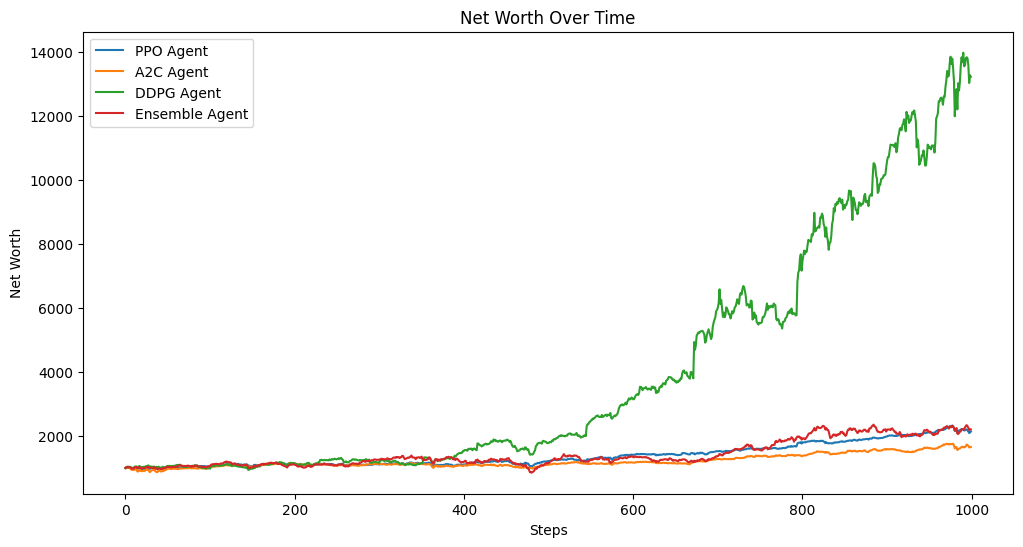

,Agent,Return,Standard Deviation,Sharpe Ratio
1,A2C Agent,1200.052263,209.058357,5.740274
0,PPO Agent,1489.493313,329.367845,4.522279
3,Ensemble Agent,1304.617432,391.119483,3.335598
2,DDPG Agent,3979.524327,3700.357908,1.075443


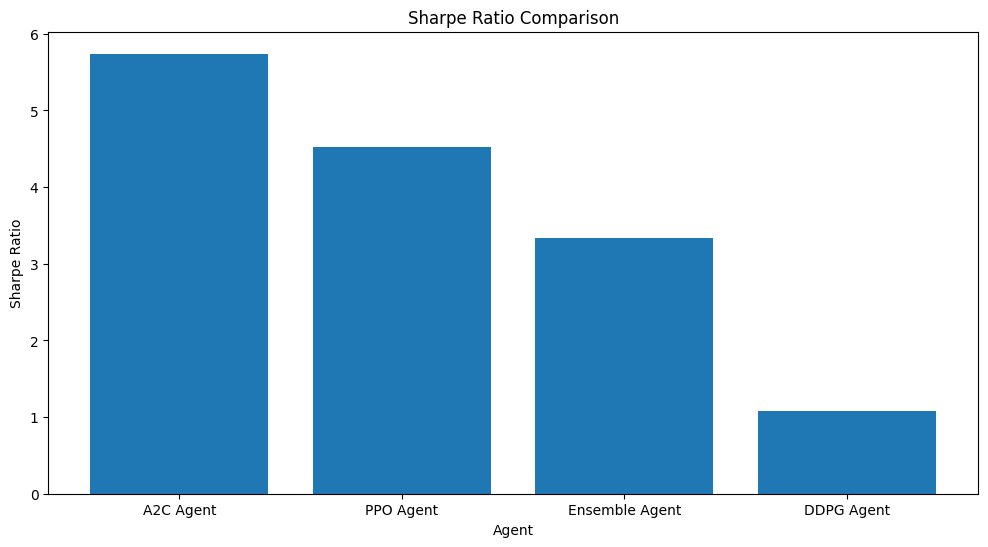

In [11]:
# 1. Create the environment and train the agents
total_timesteps = 10000
env, ppo_agent, a2c_agent, ddpg_agent, ensemble_agent = create_env_and_train_agents(training_data, total_timesteps)
print("Environment's observation space:", env.observation_space)

# 2. Test & visualize the agents
n_tests = 1000
agents = {
    'PPO Agent': ppo_agent,
    'A2C Agent': a2c_agent,
    'DDPG Agent': ddpg_agent,
    'Ensemble Agent': ensemble_agent
}
test_and_visualize_agents(env, agents, training_data, n_tests=n_tests)

# 3. Compare the agents' performance ( returns, standard deviation, and sharpe ratio )
agents_metrics = [test_agent(env, agent, training_data, n_tests=n_tests, visualize=False) for agent in agents.values()]
compare_and_plot_agents(agents_metrics, list(agents.keys()))

Testing PPO Agent...
Done testing PPO Agent!
Testing A2C Agent...
Done testing A2C Agent!
Testing DDPG Agent...
Done testing DDPG Agent!
Testing Ensemble Agent...
Done testing Ensemble Agent!
--------------------------------------------------
All agents tested!
--------------------------------------------------


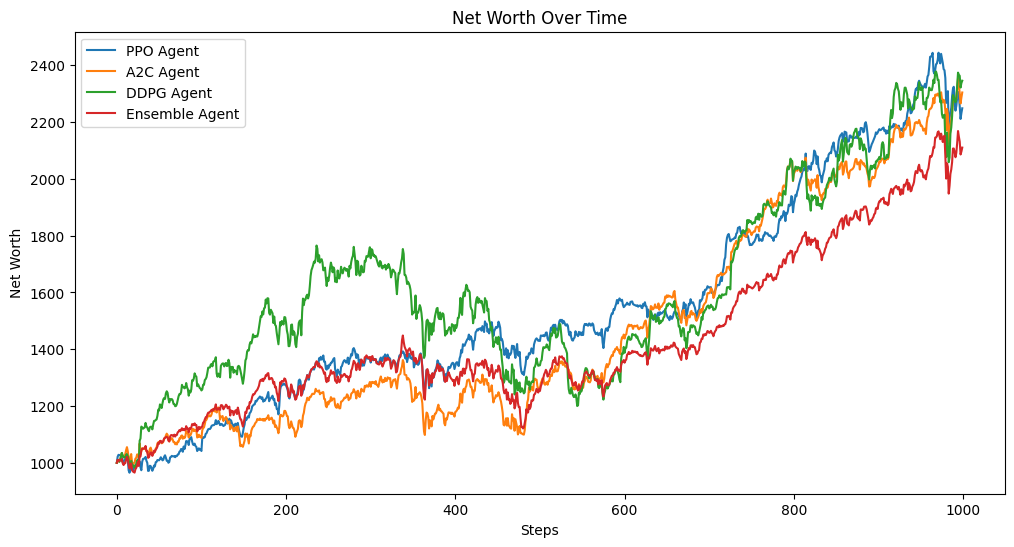

,Agent,Return,Standard Deviation,Sharpe Ratio
3,Ensemble Agent,1479.077057,305.512673,4.841295
2,DDPG Agent,1609.070655,333.184505,4.829368
0,PPO Agent,1282.553362,310.358389,4.132491
1,A2C Agent,1576.590862,411.707407,3.829396


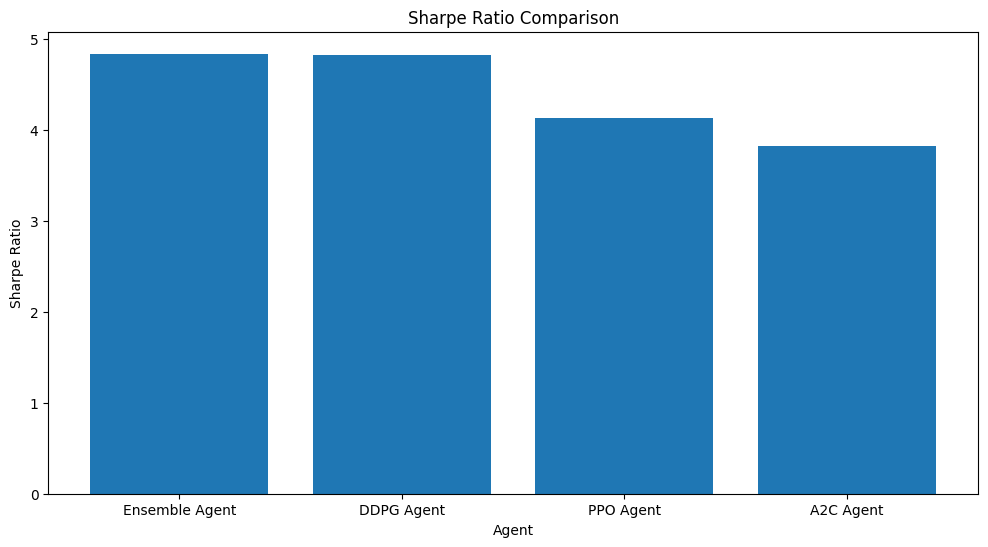

In [11]:
# Create the environment using DummyVecEnv with test data
test_env = DummyVecEnv([lambda: StockTradingEnv(test_data)])

# 2. Test & visualize the agents on the test data
n_tests = 1000
test_agents = {
    'PPO Agent': ppo_agent,
    'A2C Agent': a2c_agent,
    'DDPG Agent': ddpg_agent,
    'Ensemble Agent': ensemble_agent
}
test_and_visualize_agents(env, test_agents, test_data, n_tests=n_tests)

# 3. Compare the agents' performance on the test data ( returns, standard deviation, and sharpe ratio )
test_agents_metrics = [test_agent(env, agent, test_data, n_tests=n_tests, visualize=False) for agent in test_agents.values()]
compare_and_plot_agents(test_agents_metrics, list(test_agents.keys()))

Testing PPO Agent...
Done testing PPO Agent!
Testing A2C Agent...
Done testing A2C Agent!
Testing DDPG Agent...
Done testing DDPG Agent!
Testing Ensemble Agent...
Done testing Ensemble Agent!
--------------------------------------------------
All agents tested!
--------------------------------------------------


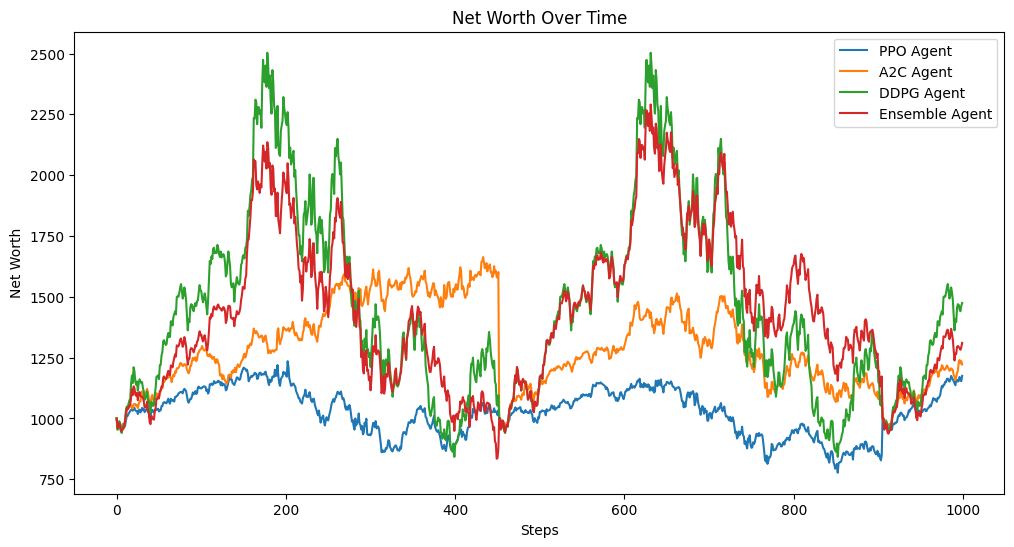

,Agent,Return,Standard Deviation,Sharpe Ratio
1,A2C Agent,1169.112114,128.053842,9.129848
0,PPO Agent,1121.277678,132.410048,8.468222
3,Ensemble Agent,1403.414581,312.993548,4.483845
2,DDPG Agent,1451.144448,385.051003,3.768707


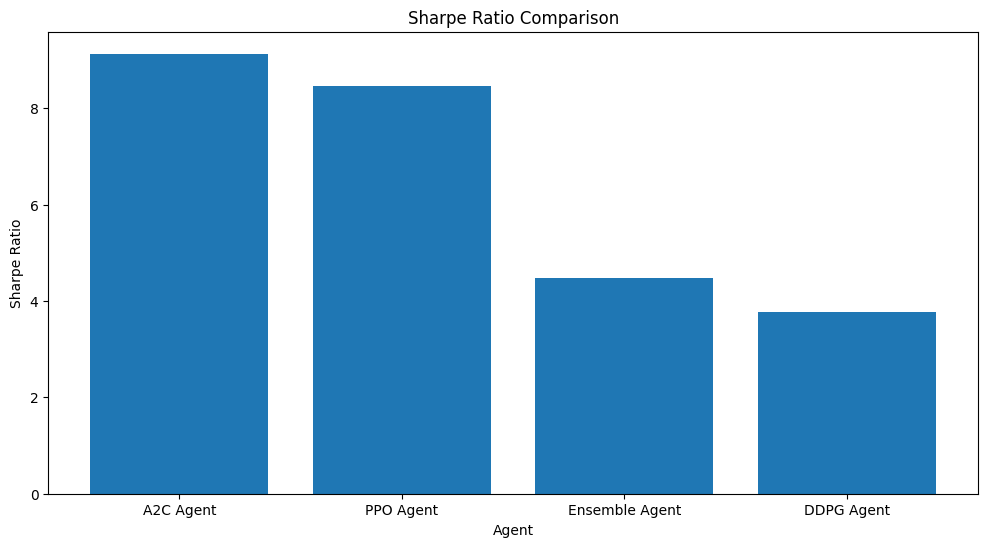

In [12]:
# create validation environment
validation_env = DummyVecEnv([lambda: StockTradingEnv(validation_data)])

# test the agents on the validation data
n_tests = 1000
validation_agents = {
    'PPO Agent': ppo_agent,
    'A2C Agent': a2c_agent,
    'DDPG Agent': ddpg_agent,
    'Ensemble Agent': ensemble_agent
}
test_and_visualize_agents(validation_env, validation_agents, validation_data, n_tests=n_tests)


validation_agents_metrics = [test_agent(validation_env, agent, validation_data, n_tests=n_tests, visualize=False) for agent in validation_agents.values()]
# compare the agents' performance on the validation data
compare_and_plot_agents(validation_agents_metrics, list(validation_agents.keys()))

In [14]:
total_timesteps = 10000  # Set the number of training steps
env, ppo_agent, a2c_agent, ddpg_agent, ensemble_agent = create_env_and_train_agents(
    {'AAPL': training_data['AAPL']},  # Train on AAPL data
    total_timesteps,
)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 5945 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 4413          |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00020756703 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | 3.27e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 6.6e+07       |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.0002       |
|    std                  | 1             |
|    value_loss          

In [15]:
print("Environment's observation space:", env.observation_space)


Environment's observation space: Box(-inf, inf, (14,), float32)
